In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_files
from sklearn.model_selection import GridSearchCV
import numpy as np
import mglearn
import matplotlib.pyplot as plt
reviews_train = load_files("data/aclImdb/train/")
unsup_index = reviews_train.target_names.index('unsup')
text_train = []
y_train = []
for t, y in zip(reviews_train.data, reviews_train.target):
    if y != unsup_index:
        text_train.append(t)
        y_train.append(y)

print("训练用评论: {}".format(len(text_train)))
print("训练用评论(按pos/neg分类): {}".format(np.bincount(y_train)))



训练用评论: 25000
训练用评论(按pos/neg分类): [12500 12500]


In [2]:
reviews_test = load_files("data/aclImdb/test/")

text_test = reviews_test.data
y_test = reviews_test.target

print("测试用评论: {}".format(len(text_test)))
print("测试用评论(按pos/neg分类): {}".format(np.bincount(y_test)))




测试用评论: 25000
测试用评论(按pos/neg分类): [12500 12500]


In [4]:
vect = CountVectorizer(min_df=5, ngram_range=(2, 2))
X_train = vect.fit(text_train).transform(text_train)
X_test = vect.transform(text_test)

print("词汇表大小: {}".format(len(vect.vocabulary_)))
print("X_train(训练用词袋特征):\n{}".format(repr(X_train)))
print("X_test(测试用词袋特征): \n{}".format(repr(X_test)))

feature_names = vect.get_feature_names()
print("特征数量: {}".format(len(feature_names)))



词汇表大小: 129549
X_train(训练用词袋特征):
<25000x129549 sparse matrix of type '<class 'numpy.int64'>'
	with 3607330 stored elements in Compressed Sparse Row format>
X_test(测试用词袋特征): 
<25000x129549 sparse matrix of type '<class 'numpy.int64'>'
	with 3392376 stored elements in Compressed Sparse Row format>
特征数量: 129549


In [6]:
%%time
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.88
Best parameters:  {'C': 0.1}
Best estimator:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
CPU times: user 4min 45s, sys: 28 ms, total: 4min 45s
Wall time: 47.8 s


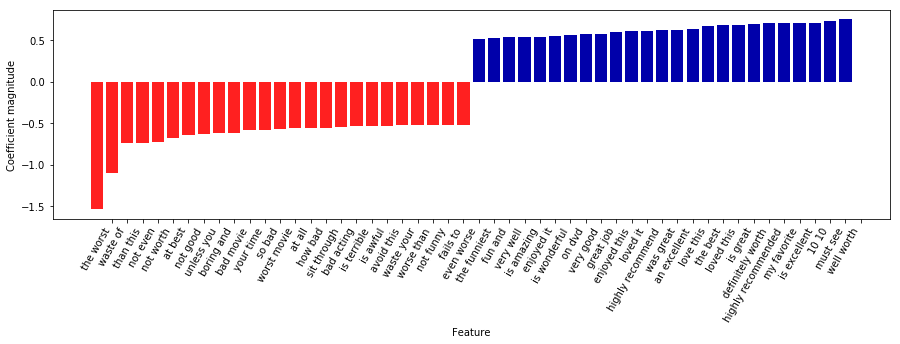

Score: 0.88


In [7]:
%matplotlib inline
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_names, n_top_features=25)
plt.show()

lr = grid.best_estimator_
lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

In [8]:
import matplotlib.pyplot as plt
from importlib import reload
reload(plt)
%matplotlib inline

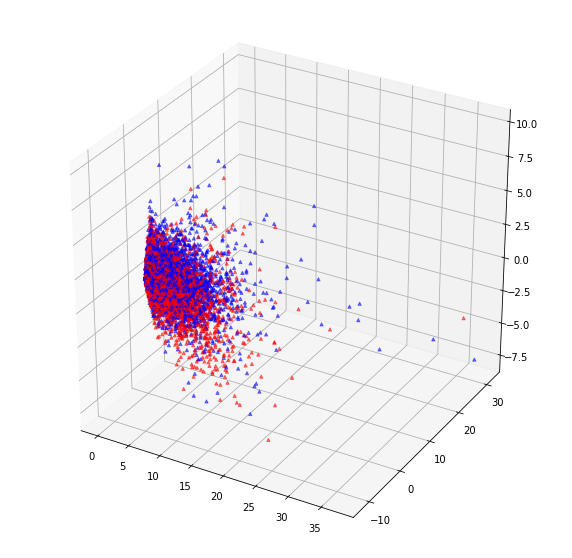

In [9]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from mpl_toolkits.mplot3d import Axes3D, axes3d

svd = TruncatedSVD(n_components=3)
pca = PCA(n_components=3)

sample_features = X_test[np.random.choice(X_test.shape[0], 10000, replace=False), :]

svd.fit(X_test)
reduced_x = svd.transform(sample_features)
pos_x,pos_y,pos_z = [],[],[]
neg_x,neg_y,neg_z = [],[],[]

y_plot_pre = lr.predict(sample_features)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_x[:,0],reduced_x[:,1],reduced_x[:,2],c=list(map(lambda x:['b','r'][x], y_plot_pre)),marker='^',s=10,alpha=0.5)

plt.show()

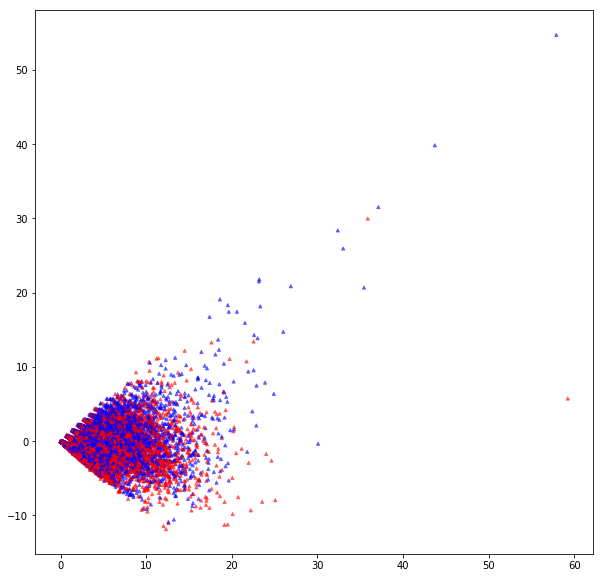

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from mpl_toolkits.mplot3d import Axes3D, axes3d

svd = TruncatedSVD(n_components=2)
pca = PCA(n_components=2)

sample_features = X_test[np.random.choice(X_test.shape[0], 25000, replace=False), :]

svd.fit(X_test)
reduced_x = svd.transform(sample_features)
pos_x,pos_y,pos_z = [],[],[]
neg_x,neg_y,neg_z = [],[],[]

y_plot_pre = lr.predict(sample_features)

for i in range(len(y_plot_pre)):
    if y_plot_pre[i] == 0:
        neg_x.append(reduced_x[i][0])
        neg_y.append(reduced_x[i][1])
    else:
        pos_x.append(reduced_x[i][0])
        pos_y.append(reduced_x[i][1])

fig = plt.figure(figsize=(10,10))

plt.scatter(reduced_x[:,0],reduced_x[:,1],c=list(map(lambda x:['b','r'][x], y_plot_pre)),marker='^',s=10,alpha=0.5)

plt.show()

<Figure size 432x288 with 0 Axes>

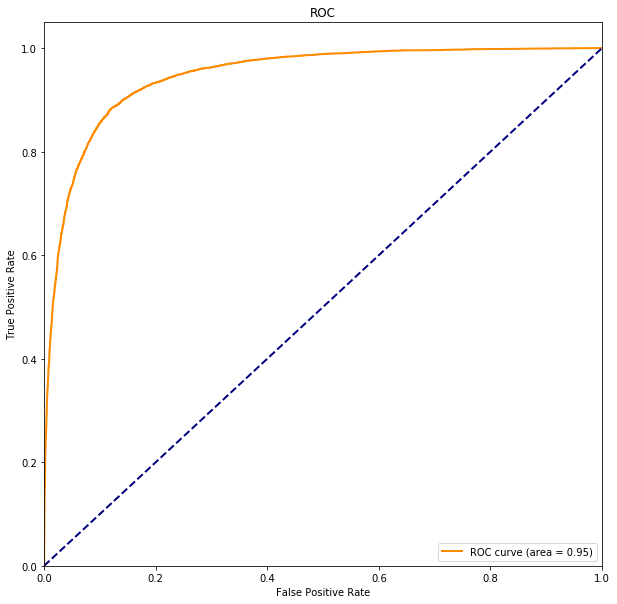

In [11]:
from sklearn.metrics import roc_curve, auc

y_plot_pre = grid.decision_function(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_plot_pre) ###计算真正率和假正率
roc_auc = auc(fpr, tpr) ###计算auc的值
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

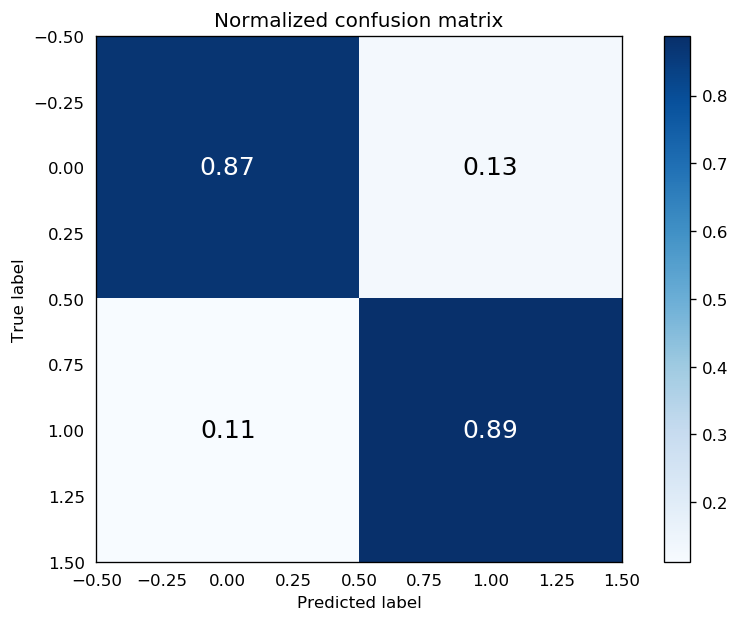

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_plot_pre = lr.predict(X_test)
cm = confusion_matrix(y_test, y_plot_pre)

np.set_printoptions(precision=2)
cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(9,6), dpi=120)
ind_array = np.arange(2)
x, y = np.meshgrid(ind_array, ind_array)
 
for x_val, y_val in zip(x.flatten(), y.flatten()):
    thresh = cm_normalized.max()/2
    c = cm_normalized[y_val][x_val]
    if (c > 0.01):
        plt.text(x_val, y_val, "%0.2f" %(c,), color='white' if cm_normalized[x_val, y_val] > thresh else "black", fontsize=15, va='center', ha='center')
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)
 
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
#show confusion matrix
plt.show()